{'results_dir': '/home/benito/script/KPIs24/results/', 'datadir': '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/', 'device_number': 0, 'seed': 0, 'training': {'epoch': 100, 'val_interval': 1, 'nfolds': 5, 'train_batch_size': 4, 'val_batch_size': 1, 'num_workers': 0, 'roi_size': [512, 512], 'sw_batch_size': 4, 'learning_rate': 0.001}, 'model': {'name': 'Unet', 'params': {'in_channels': 3, 'spatial_dims': 2, 'out_channels': 1, 'f_maps_channels': [32, 64, 128, 256, 512], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'final_activation': 'Sigmoid', 'norm': 'batch', 'dropout': 0.0, 'padding': 1, 'up_mode': 'upconv', 'deep_supervision': False}, 'optimizer': {'name': 'Adam', 'params': {'learning_rate': 0.001, 'weight_decay': 0.0001}}, 'scheduler': {'name': 'WarmupCosineSchedule', 'params': {'warmup_epochs': 5, 'cycles': 0.5}}}, 'wandb': {'state': False, 'project': 'nefrobit', 'entity': 'nefrobit', 'reinit': True, 'resume': 'allow', 'group_name': 'KPIs24', 'exp': 'cropposneg'}}


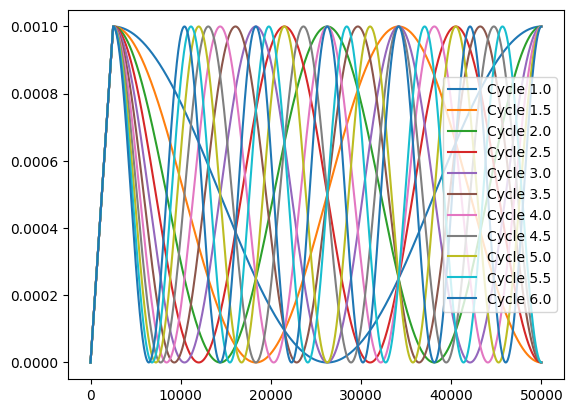

In [40]:
import monai
import torch
from monai.optimizers import WarmupCosineSchedule
import yaml
import matplotlib.pyplot as plt
import numpy as np

with open('/home/benito/script/KPIs24/config_train.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

print(cfg)

device = torch.device(f"cuda:{cfg['device_number']}" if torch.cuda.is_available() else "cpu")

model = monai.networks.nets.UNet(
        spatial_dims=cfg['model']['params']['spatial_dims'],
        in_channels=cfg['model']['params']['in_channels'],
        out_channels=cfg['model']['params']['out_channels'],
        channels=cfg['model']['params']['f_maps_channels'],
        strides=cfg['model']['params']['strides'],
        num_res_units=cfg['model']['params']['num_res_units'],
    ).to(device)

warmup_steps= int(cfg['model']['scheduler']['params']['warmup_epochs'] * 500 * cfg['training']['sw_batch_size'] / 4)
t_total = int(cfg['training']['epoch']* 500 * cfg['training']['sw_batch_size'] / 4)

for cycle in np.linspace(0, 5, 11):
    optimizer = torch.optim.Adam(model.parameters(), cfg['model']['optimizer']['params']['learning_rate'])
    scheduler = WarmupCosineSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total, cycles = cycle+1, end_lr=1e-9)
    lr_values = []
    for steps in range(t_total):
        lr = scheduler.get_lr()[0]
        lr_values.append(lr)
        optimizer.step()
        scheduler.step()
    plt.plot(range(t_total), lr_values, label=f'Cycle {cycle+1}')
plt.legend()
plt.show()
    